
# Transportation & Mobility Visualization with City2Graph

This notebook demonstrates how to create transportation and mobility visualizations using `city2graph`:

1. **Travel Summary Graph** - Visualization of transit connections from GTFS data
2. **OD Matrix Graph** - Origin-Destination flow visualization from ridership data

We'll use NYC subway data as an example, following the same data structure as the NYC challenge notebook.

## 1. Import Required Libraries

In [1]:
from pathlib import Path

import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
from shapely import wkt
from shapely.geometry import Point, box

import city2graph as c2g

# Set plotting style
plt.style.use("default")
get_ipython().run_line_magic('matplotlib', 'inline')

## 2. Define Data Paths

Data files are expected to be in the `data/` directory:
- `data/gtfs_subway.zip` - GTFS feed for subway system
- `data/MTA_Subway_Origin-Destination_Ridership_Estimate.csv` - OD ridership data

In [2]:
# Define data paths
DATA_DIR = Path("data")
GTFS_PATH = DATA_DIR / "gtfs_subway.zip"
OD_DATA_PATH = DATA_DIR / "MTA_Subway_Origin-Destination_Ridership_Estimate__Beginning_2025.csv"

# Check if files exist
print(f"GTFS data exists: {GTFS_PATH.exists()}")
print(f"OD data exists: {OD_DATA_PATH.exists()}")

GTFS data exists: True
OD data exists: True


---
# Travel Summary Graph
 
The travel summary graph represents transit connections derived from GTFS data.
Each node represents a transit stop, and edges represent direct connections with travel time weights.

## 3. Load GTFS Data

In [3]:
gtfs = c2g.load_gtfs(str(GTFS_PATH))

In [4]:
gtfs['calendar']

service_id  monday  tuesday  wednesday  thursday  friday  saturday  sunday  \
0     Sunday   False    False      False     False   False     False    True   
1   Saturday   False    False      False     False   False      True   False   
2    Weekday    True     True       True      True    True     False   False   

  start_date  end_date  
0   20251102  20251207  
1   20251102  20251207  
2   20251102  20251207

## 4. Create Travel Summary Graph

In [5]:
travel_summary_nodes, travel_summary_edges = c2g.travel_summary_graph(
    gtfs,
    start_time="06:00:00",
    end_time="10:00:00",
    calendar_start="20251103",
    calendar_end="20251103",
    as_nx=False)

In [6]:
# Exclude nodes and edges of Staten Island
# Staten Island bounding box (approximate): lon -74.26 to -74.04, lat 40.48 to 40.65
staten_island_bbox = box(-74.26, 40.48, -74.04, 40.65)

# Filter out nodes that are within Staten Island
travel_summary_nodes = travel_summary_nodes[
    ~travel_summary_nodes.geometry.within(staten_island_bbox)
]

# Get the list of valid node IDs (not in Staten Island)
valid_node_ids = set(travel_summary_nodes.index)

# Filter edges where both source and target are valid (not in Staten Island)
# The edges dataframe has a MultiIndex, so we access levels from the index
edge_sources = travel_summary_edges.index.get_level_values(0)
edge_targets = travel_summary_edges.index.get_level_values(1)
travel_summary_edges = travel_summary_edges[
    edge_sources.isin(valid_node_ids) &
    edge_targets.isin(valid_node_ids)
]

print(f"Nodes after filtering: {len(travel_summary_nodes)}")
print(f"Edges after filtering: {len(travel_summary_edges)}")

# Create NetworkX graph from filtered nodes and edges
travel_summary_G = c2g.gdf_to_nx(travel_summary_nodes, travel_summary_edges)
print("Travel Summary Graph Statistics:")
print(f"  Number of nodes: {travel_summary_G.number_of_nodes()}")
print(f"  Number of edges: {travel_summary_G.number_of_edges()}")

Nodes after filtering: 1425
Edges after filtering: 1273
Travel Summary Graph Statistics:
  Number of nodes: 1425
  Number of edges: 756


/Users/yutasato/Projects/Liverpool/city2graph-case-study/.venv/lib/python3.13/site-packages/city2graph/base.py:784: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return gdf.geometry.centroid


## 5. Visualize Travel Summary Graph

In [7]:
travel_nodes, travel_edges = c2g.nx_to_gdf(travel_summary_G)
travel_nodes_plot = travel_nodes.to_crs(epsg=3857)
travel_edges_plot = travel_edges.to_crs(epsg=3857)

# Hourly frequency
travel_edges_plot["frequency"] = travel_edges_plot["frequency"] / 4

<Axes: >

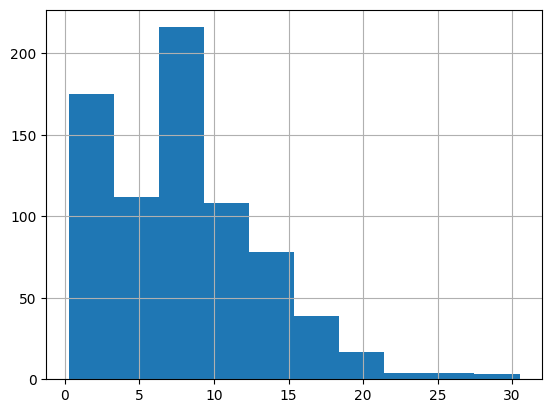

In [8]:
travel_edges_plot["frequency"].hist()

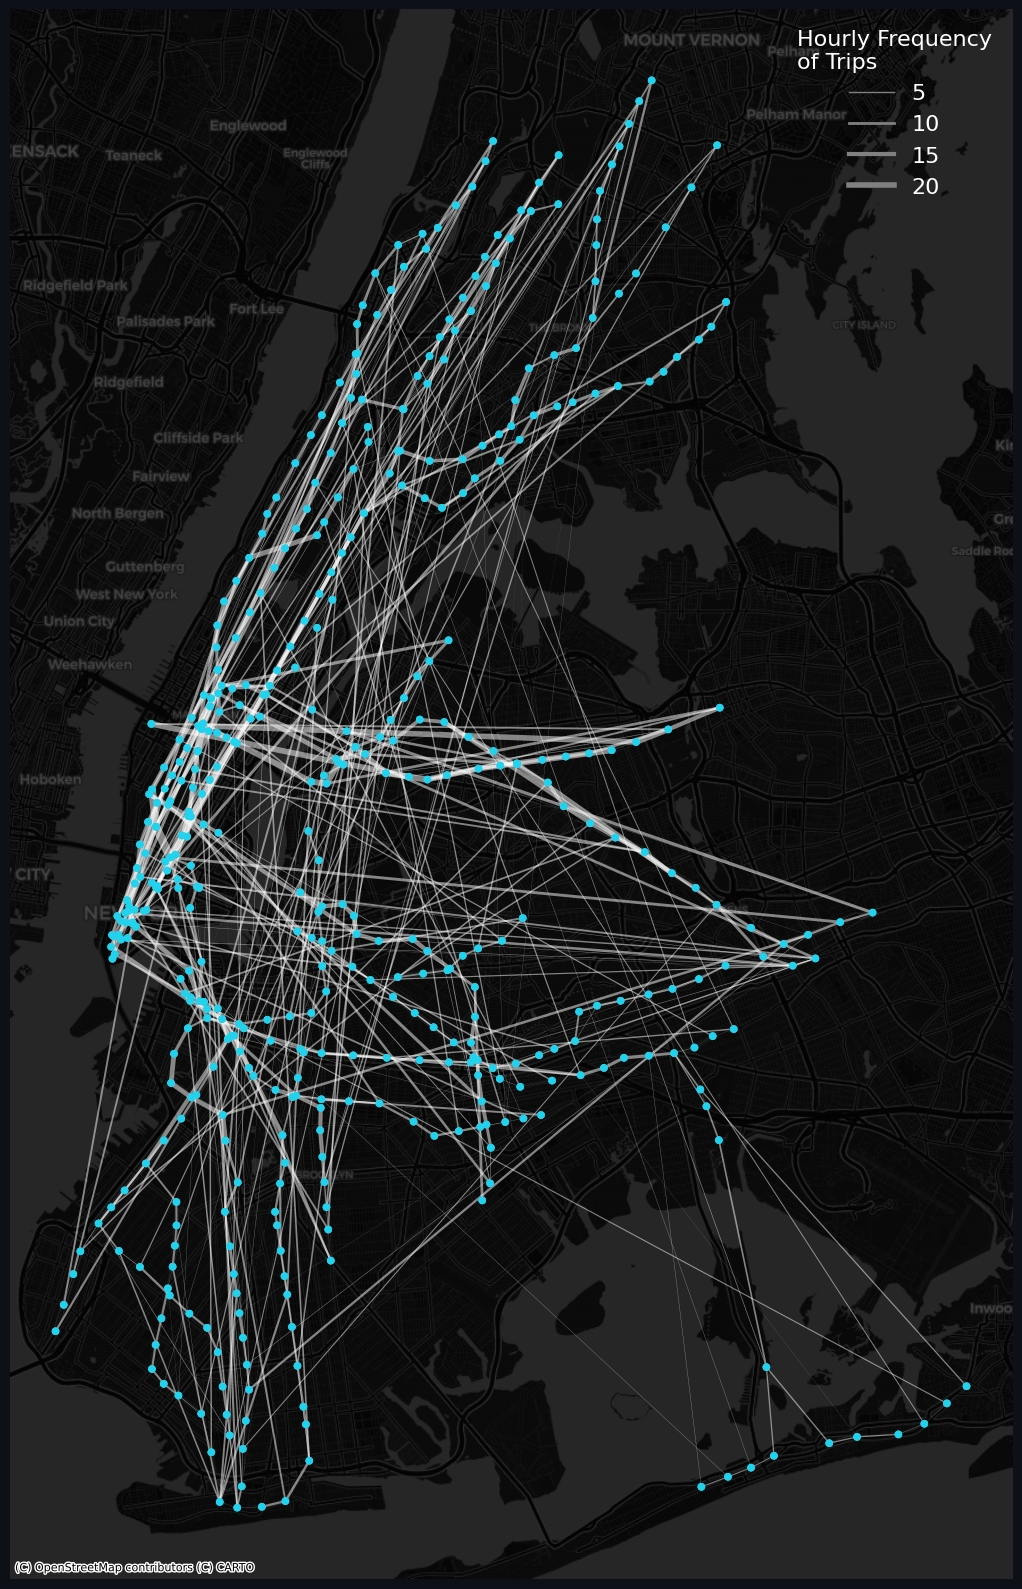

In [9]:
# Create figure with dark theme
fig, ax = plt.subplots(figsize=(16, 16))

# Plot using city2graph's plot_graph with attribute mapping
c2g.plot_graph(
    nodes=travel_nodes_plot,
    edges=travel_edges_plot,
    ax=ax,
    bgcolor='#0d1117',
    # Node styling
    node_alpha=0.9,
    markersize=30,
    # Edge styling
    edge_color='travel_time_sec',      # Map color to frequency
    #cmap='plasma',               # Use high-contrast colormap
    edge_linewidth=travel_edges_plot['frequency']/5,  # Scaled widths
    edge_alpha=0.5,
)


# Add legend for edge linewidth
legend_values = [5, 10, 15, 20]

legend_elements = [
    Line2D([0], [0], color='gray', lw=val/5, label=f'{val}')
    for val in legend_values
]
leg = ax.legend(
    handles=legend_elements, 
    title="Hourly Frequency\nof Trips ", 
    loc="upper right", 
    frameon=False, 
    labelcolor='white',
    fontsize=16,
    title_fontsize=16
)
plt.setp(leg.get_title(), color='white')
# Add dark basemap
cx.add_basemap(ax, source=cx.providers.CartoDB.DarkMatter, zoom=12)

# Style the plot
ax.set_axis_off()
plt.tight_layout()
plt.show()


# OD Matrix Graph

The Origin-Destination (OD) matrix graph represents flow patterns between locations.
Each node represents a station/zone, and edges represent ridership flows weighted by volume.

## 6. Load OD Matrix Data

In [10]:
# Load MTA subway OD data
print(f"Loading OD data from: {OD_DATA_PATH}")
od_data = pd.read_csv(OD_DATA_PATH)

print(f"\nOD data shape: {od_data.shape}")
print(f"\nColumns: {od_data.columns.tolist()}")
print("\nFirst few rows:")
display(od_data.head())

Loading OD data from: data/MTA_Subway_Origin-Destination_Ridership_Estimate__Beginning_2025.csv

OD data shape: (127671, 7)

Columns: ['Origin Station Complex Name', 'Destination Station Complex Name', 'Origin Station Complex ID', 'Destination Station Complex ID', 'Origin Point', 'Destination Point', 'avg_estimated_average_ridership']

First few rows:


Origin Station Complex Name Destination Station Complex Name  \
0             Beach 44 St (A)                     Grand St (L)   
1                 30 Av (N,W)                 Simpson St (2,5)   
2         Northern Blvd (M,R)                         2 Av (F)   
3             Pelham Pkwy (5)  Grand Central-42 St (S,4,5,6,7)   
4                   80 St (A)                  New Lots Av (L)   

   Origin Station Complex ID  Destination Station Complex ID  \
0                        206                             123   
1                          3                             430   
2                        269                             232   
3                        445                             610   
4                        190                             136   

                   Origin Point             Destination Point  \
0  POINT (-73.776013 40.592943)   POINT (-73.94067 40.711926)   
1  POINT (-73.921479 40.766779)  POINT (-73.893064 40.824073)   
2  POINT (-73.906006 40.752885)  POINT (-73.989938 40.723402)   
3  POINT (-73.855359 40.858985)  POINT (-73.977359 40.751992)   
4  POINT (-73.858992 40.679371)  POINT (-73.899232 40.658733)   

   avg_estimated_average_ridership  
0                         0.323000  
1                         0.569267  
2                         1.531520  
3                        20.349060  
4                         1.031250

## 7. Extract Unique Station Locations

In [11]:
# Extract unique stations with their geometries from OD data
if od_data is not None:
    stations = {}

    # Process origin stations
    for idx, row in od_data.iterrows():
        station_name = row["Origin Station Complex Name"]
        if station_name not in stations:
            point_str = row["Origin Point"]
            point = wkt.loads(point_str)
            stations[station_name] = {"geometry": point, "lon": point.x, "lat": point.y}

    # Process destination stations
    for idx, row in od_data.iterrows():
        station_name = row["Destination Station Complex Name"]
        if station_name not in stations:
            point_str = row["Destination Point"]
            point = wkt.loads(point_str)
            stations[station_name] = {"geometry": point, "lon": point.x, "lat": point.y}

    # Convert to GeoDataFrame
    stations_df = pd.DataFrame.from_dict(stations, orient="index")
    stations_df["station_name"] = stations_df.index

    stations_gdf = gpd.GeoDataFrame(
        stations_df,
        geometry="geometry",
        crs="EPSG:4326",  # WGS84
    )

    # Reproject to NYC local CRS (NAD83 / New York Long Island)
    stations_gdf = stations_gdf.to_crs(epsg=2263)

    print(f"Total unique stations: {len(stations_gdf)}")
    print(f"CRS: {stations_gdf.crs}")
    print("\nFirst few stations:")
    display(stations_gdf.head())
else:
    stations_gdf = None
    print("OD data not available.")

Total unique stations: 424
CRS: EPSG:2263

First few stations:


geometry        lon        lat  \
Beach 44 St (A)      POINT (1046456.966 155381.067) -73.776013  40.592943   
30 Av (N,W)          POINT (1006000.556 218644.773) -73.921479  40.766779   
Northern Blvd (M,R)  POINT (1010292.054 213586.957) -73.906006  40.752885   
Pelham Pkwy (5)          POINT (1024260.514 252262) -73.855359  40.858985   
80 St (A)             POINT (1023360.896 186821.07) -73.858992  40.679371   

                            station_name  
Beach 44 St (A)          Beach 44 St (A)  
30 Av (N,W)                  30 Av (N,W)  
Northern Blvd (M,R)  Northern Blvd (M,R)  
Pelham Pkwy (5)          Pelham Pkwy (5)  
80 St (A)                      80 St (A)

## 8. Create OD Matrix Graph

In [12]:
c2g.od_matrix_to_graph?

Signature:
c2g.od_matrix_to_graph(
    od_data: 'pd.DataFrame | np.ndarray',
    zones_gdf: 'gpd.GeoDataFrame',
    zone_id_col: 'str | None' = None,
    *,
    matrix_type: "Literal['edgelist', 'adjacency']" = 'edgelist',
    source_col: 'str' = 'source',
    target_col: 'str' = 'target',
    weight_cols: 'list[str] | None' = None,
    threshold: 'float | None' = None,
    threshold_col: 'str | None' = None,
    include_self_loops: 'bool' = False,
    compute_edge_geometry: 'bool' = True,
    directed: 'bool' = True,
    as_nx: 'bool' = False,
) -> 'tuple[gpd.GeoDataFrame, gpd.GeoDataFrame] | nx.Graph | nx.DiGraph'
Docstring:
Convert OD data (edge list or adjacency matrix) into graph structures.

Creates spatially-aware graphs from OD data following city2graph's
GeoDataFrame-first design. Supports adjacency matrices (DataFrame or
ndarray) and edgelists with one or multiple numeric weight columns.
By default, this function returns a pair of GeoDataFrames representing
nodes and edges. W

In [13]:
# Create OD matrix graph from subway ridership data
print("Creating OD matrix graph...")

od_G = c2g.od_matrix_to_graph(
    od_data,
    zones_gdf=stations_gdf,
    source_col="Origin Station Complex Name",
    target_col="Destination Station Complex Name",
    weight_cols=["avg_estimated_average_ridership"],
    as_nx=True,
)

print("\nOD Matrix Graph Statistics:")
print(f"  Number of stations (nodes): {od_G.number_of_nodes()}")
print(f"  Number of OD pairs (edges): {od_G.number_of_edges()}")

Creating OD matrix graph...

OD Matrix Graph Statistics:
  Number of stations (nodes): 424
  Number of OD pairs (edges): 127671


## 9. Visualize OD Matrix Graph

In [41]:
od_nodes, od_edges = c2g.nx_to_gdf(od_G)
od_nodes_plot = od_nodes.to_crs(epsg=3857)
od_edges_plot = od_edges.to_crs(epsg=3857)

In [37]:
# Make sure avg_estimated_average_ridership is between 0.01 to 0.99 quantiles
od_edges_plot = od_edges_plot[
    (od_edges_plot['avg_estimated_average_ridership'] >= od_edges_plot['avg_estimated_average_ridership'].quantile(0.01)) &
    (od_edges_plot['avg_estimated_average_ridership'] <= od_edges_plot['avg_estimated_average_ridership'].quantile(0.99))
]

In [42]:
# Make sure avg_estimated_average_ridership is between 0.01 to 0.99 quantiles
od_edges_plot = od_edges_plot[
    (od_edges_plot['avg_estimated_average_ridership'] >= 1)
]

In [43]:
od_edges_plot['avg_estimated_average_ridership'].describe()

count    47737.000000
mean         5.321790
std         12.661148
min          1.000000
25%          1.347933
50%          2.136560
75%          4.724260
max        634.524580
Name: avg_estimated_average_ridership, dtype: float64

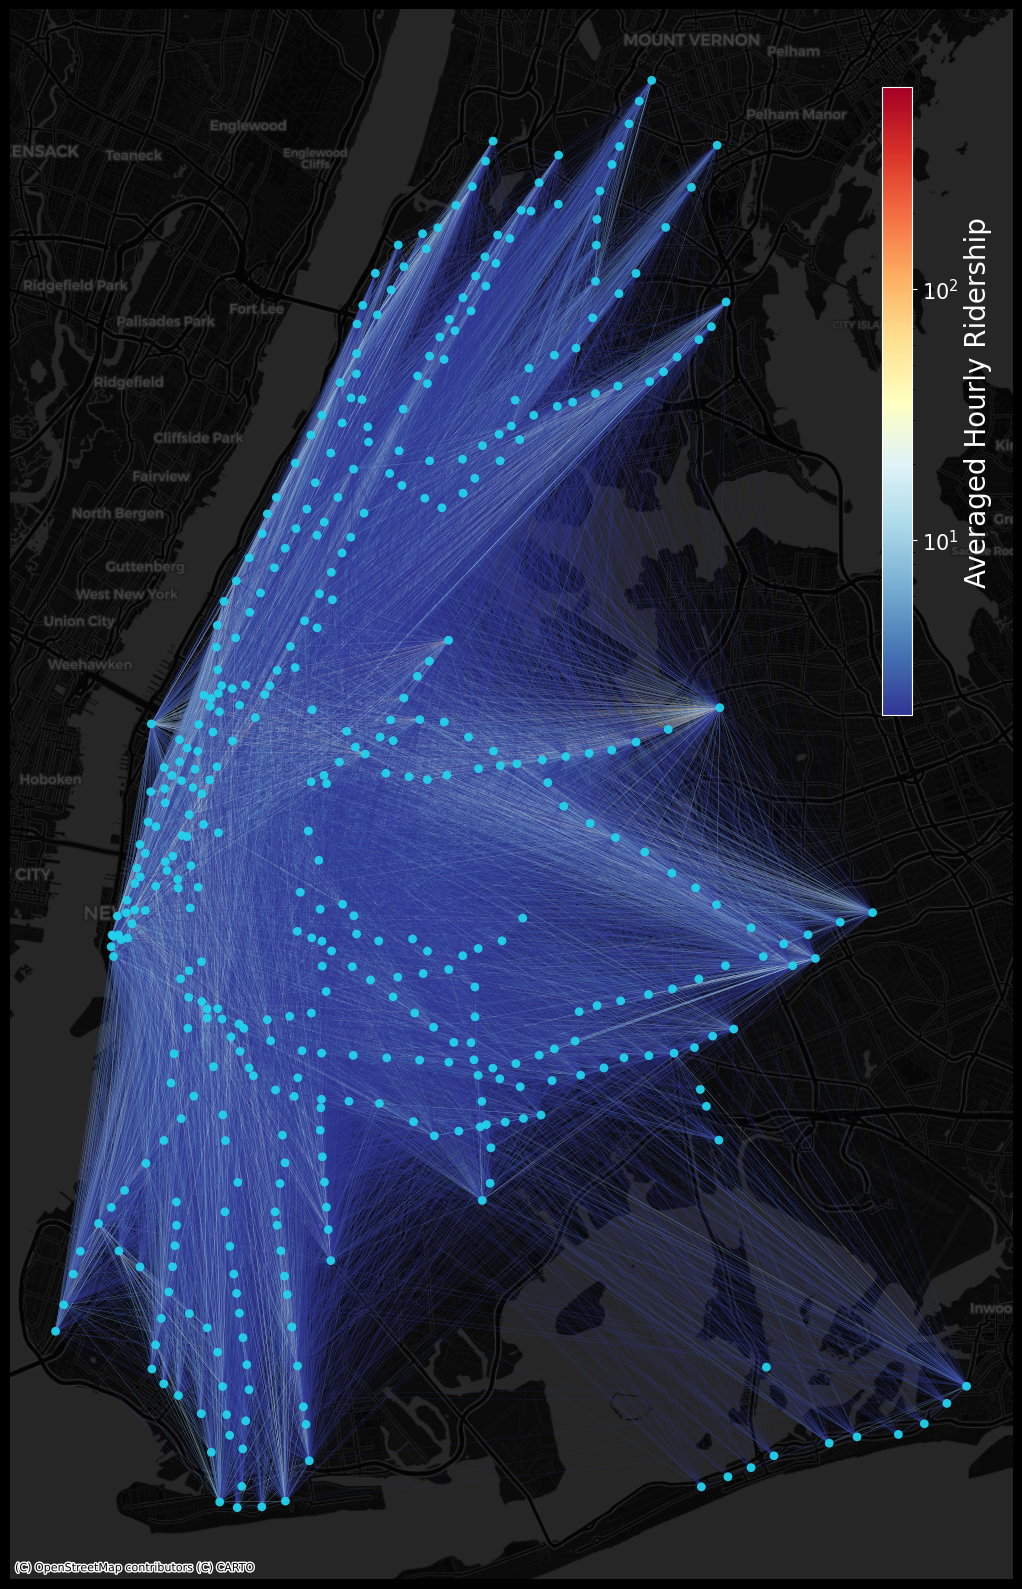

In [45]:
# Create another version of the OD matrix plot with edges colored by ridership
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Create figure with dark theme
fig, ax = plt.subplots(figsize=(16, 16), facecolor='black')

# Prepare colormap based on ridership
ridership = od_edges_plot['avg_estimated_average_ridership']
# Use LogNorm to handle skewed distribution and better visualize variations
norm = mcolors.LogNorm(vmin=ridership.min() + 1, vmax=ridership.max())
cmap = cm.RdYlBu_r

# Create scalar mappable for colorbar and edge colors
m = cm.ScalarMappable(norm=norm, cmap=cmap)
edge_colors = m.to_rgba(ridership)

# Reuse edge widths from previous cell or recalculate if needed
# Ensure consistent width scaling
width_scale = 0.5
edge_widths = np.log1p(ridership) * width_scale

# Plot using city2graph's plot_graph
c2g.plot_graph(
    nodes=od_nodes_plot,
    edges=od_edges_plot,
    ax=ax,
    # Node styling
    node_alpha=0.95,
    markersize=40,
    # Edge styling
    edge_linewidth=0.1,
    edge_color=edge_colors,
    edge_alpha=1
)

# Create inset axes for colorbar inside the plot
# [x, y, width, height] relative to parent axes
cax = ax.inset_axes([0.87, 0.55, 0.03, 0.4])

# Add colorbar to the inset axes
cbar = plt.colorbar(m, cax=cax)
cbar.set_label('Averaged Hourly Ridership', color='white', fontsize=20)
cbar.ax.yaxis.set_tick_params(color='white', labelcolor='white', labelsize=15)
cbar.outline.set_edgecolor('white')

# Add dark basemap
cx.add_basemap(ax, source=cx.providers.CartoDB.DarkMatter, zoom=12)

ax.set_axis_off()
plt.tight_layout()
plt.show()